# Viruses per host celltypes

In [1]:
bp = "PRJNA665227"
fastq_folder = f"/home/laura/projects/virus-watch-data/{bp}"
u_tax = f"/home/laura/projects/virus-watch-data/virus_ref/u_tax_nodup_clu.csv"

In [2]:
import anndata
import numpy as np
import random
import pandas as pd
import json
import gget
import os
import glob
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
%load_ext blackcellmagic

import scanpy as sc
# sc.set_figure_params(figsize=(6, 6), frameon=False)
# sc.settings.n_jobs=2

# Path to Krona tool
ktImportText = "/home/laura/bin/ktImportText"

def nd(arr):
    """
    Function to transform numpy matrix to nd array.
    """
    return np.asarray(arr).reshape(-1)

def flatten(xss):
    """
    Function to flatten array of arrays.
    """
    return [x for xs in xss for x in xs]

Fri Nov 17 13:43:12 2023 INFO Generating grammar tables from /home/laura/anaconda3/lib/python3.9/site-packages/blib2to3/Grammar.txt
Fri Nov 17 13:43:12 2023 INFO Writing grammar tables to /home/laura/.cache/black/21.12b0/Grammar3.9.12.final.0.pickle
Fri Nov 17 13:43:12 2023 INFO Writing failed: [Errno 2] No such file or directory: '/home/laura/.cache/black/21.12b0/tmp8s3pbruq'
Fri Nov 17 13:43:12 2023 INFO Generating grammar tables from /home/laura/anaconda3/lib/python3.9/site-packages/blib2to3/PatternGrammar.txt
Fri Nov 17 13:43:12 2023 INFO Writing grammar tables to /home/laura/.cache/black/21.12b0/PatternGrammar3.9.12.final.0.pickle
Fri Nov 17 13:43:12 2023 INFO Writing failed: [Errno 2] No such file or directory: '/home/laura/.cache/black/21.12b0/tmparoh2dip'


___
# Load data

In [3]:
# Macaque only
host_adata = anndata.read(f"{fastq_folder}/full_index_stringent_dlist_flank1/macaque_QC_norm_leiden_celltypes.h5ad")
host_adata

AnnData object with n_obs × n_vars = 202525 × 66553
    obs: 'sample_barcode', 'barcode', 'srr', 'n_counts', 'n_genes', 'percent_mito', 'species', 'Run', 'donor_animal', 'Experiment', 'mdck_spike_in', 'hours_post_innoculation', 'day_post_infection', 'dpi', 'dpi_accessions', 'dpi_clean', 'leiden', 'celltype_clusters', 'celltype', 'dpi_clean_merged'
    var: 'gene_id', 'species', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'gene_symbol'
    uns: 'dendrogram_leiden', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [4]:
palmdb_adata = anndata.read(f"{fastq_folder}/host_flag/virus_cdna_dna_masked_meta.h5ad")
palmdb_adata

AnnData object with n_obs × n_vars = 225898 × 11176
    obs: 'sample_barcode', 'srr', 'Run', 'donor_animal', 'Experiment', 'mdck_spike_in', 'hours_post_innoculation', 'day_post_infection', 'dpi', 'dpi_accessions', 'dpi_clean', 'leiden', 'celltype_clusters', 'celltype', 'species', 'dpi_clean_merged'
    var: 'v_type'

Load ID to phylogeny mapping:

In [5]:
id2tax = pd.read_csv(u_tax)
id2tax

,ID,rep_ID,phylum,class,order,family,genus,species,strandedness
0,u1,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
1,u10066,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
2,u10121,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
3,u10124,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
4,u102609,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
...,...,...,...,...,...,...,...,...,...
296556,u296608,u296608,.,.,.,.,.,.,unknown
296557,u296609,u296609,.,.,.,.,.,.,unknown
296558,u296613,u296613,.,.,.,.,.,.,unknown
296559,u296616,u296616,.,.,.,.,.,.,unknown


___
# EBOV counts per timepoint

In [6]:
# def rand_jitter(arr, jitter_size=0.02):
#     """
#     Add random jitter to array to avoid overplotting.
#     """
#     arr = np.array(arr)
#     stdev = jitter_size * max(arr)
#     return arr + np.random.randn(len(arr)) * stdev

def rand_jitter(arr, jitter_size=0.02):
    """
    Add random jitter to array to avoid overplotting.
    """
    return np.random.uniform(low=-jitter_size, high=jitter_size, size=(len(arr),))

Group timepoints:

In [7]:
palmdb_adata.obs["dpi_grouped"] = palmdb_adata.obs["dpi_clean_merged"]
dpi_dict = {"-30d":"pre-infection", "-4d":"pre-infection", "0d":"pre-infection", "4h":"4h", "24h":"24h", "3d":"early", "4d":"middle", "5d":"middle", "6d":"late", "7d/8d":"late"}

palmdb_adata.obs = palmdb_adata.obs.replace({"dpi_grouped": dpi_dict})

In [8]:
# %%time

# def count_true(lst):
#     "Count occurence of True in list."
#     return sum(bool(x) for x in lst)

# fig, axs = plt.subplots(figsize=(9, 7), nrows=2, sharex=True)
# fontsize = 16
# width = 0.65
# color = "tab:red"

# samples = ["pre-infection", "4h", "24h", "early", "middle", "6d", "7d/8d"]
# labels = ["Baseline\n(-30-0d)", "Incubation\n(4h)", "Incubation\n(24h)", "Early\n(3d)", "Middle\n(4-5d)", "Late\n(6d)", "Late\n(7/8d)"]
# target_ids = id2tax[id2tax["species"].str.contains("Zaire ebolavirus")]["rep_ID"].unique()

# # Plot number of ZEBOV counts per timepoint
# ax = axs[0]

# cellnums_mean = []
# cellnums_std = []
# total_num_cells = []
# for sample in samples:
#     # Get total number of cells in sample
#     total = len(palmdb_adata.obs[(palmdb_adata.obs["celltype"].notnull()) & (palmdb_adata.obs["dpi_grouped"] == sample)])
#     total_num_cells.append(total)
    
#     # Pick 1k cells at random X times and record number of positive cells
#     pos_cells = []
#     n = 1000
#     for it in np.arange(100):
#         palmdb_adata_temp = palmdb_adata[(palmdb_adata.obs["celltype"].notnull()) & (palmdb_adata.obs["dpi_grouped"] == sample), palmdb_adata.var.index.isin(target_ids)].copy()
#         random_barcodes = random.sample(palmdb_adata_temp.obs.index.values.tolist(), n)
#         palmdb_adata_temp = palmdb_adata_temp[palmdb_adata_temp.obs.index.isin(random_barcodes)]
#         pos_cells.append(count_true(nd(palmdb_adata_temp.X.todense() > 0)))
    
#     cellnums_mean.append(np.mean(pos_cells))
#     cellnums_std.append(np.std(pos_cells))

# x = np.arange(len(labels))

# ax.bar(
#     x,
#     cellnums_mean,
#     width=width,
#     # label=f"EBOV+ cells",
#     color=color,
#     alpha=1,
#     edgecolor="black",
# )

# ax.errorbar(
#     x,
#     cellnums_mean,
#     yerr=cellnums_std,
#     color="black",
#     elinewidth=1.5,
#     linewidth=0
# )

# # Add total number of cells per condition
# for x_idx, nc in enumerate(total_num_cells):
#     ax.text(x_idx, 75, "{:,}".format(nc), color="black", fontsize=fontsize, va="bottom", ha="center")

# ax.set_yscale("symlog")
# ax.set_ylabel("# ZEBOV+ cells\nper 1k cells", fontsize=fontsize)
# # ax.set_xlabel("Timepoint", fontsize=fontsize)
# # ax.legend(loc="upper left", fontsize=fontsize)

# # ax.set_xticks(x, samples, rotation=0, ha="center")

# ax.tick_params(axis="both", labelsize=fontsize)
# # ax.set_title(
# #     f"Number of Zaire ebolavirus (ZEBOV) positive cells over time",
# #     fontsize=fontsize + 2,
# # )

# ax.grid(True, which="both", color="lightgray")
# ax.set_axisbelow(True)
# ax.xaxis.grid(False)

# # Plot number of distinct sOTUS detected
# ax = axs[1]

# all_species_nums = [] # Collect all vector for significance testing
# x = np.arange(len(samples))
# for i, cluster in enumerate(samples):
#     # Get number of virus species with non-zero counts per cell in cluster
#     # Only taking into account viruses that pass the filtering threhsold and are seen in macaque (or canis for MDCK) only
#     array = np.array(palmdb_adata[(palmdb_adata.obs["celltype"].notnull()) & (palmdb_adata.obs['dpi_grouped']==cluster), (palmdb_adata.var.index.isin(target_virs)) & (palmdb_adata.var["v_type"] == "macaca_only")].X.todense())
#     species_nums = (array > 0).sum(1)
#     mean = np.mean(species_nums)
    
#     v = ax.violinplot(species_nums, [x[i]], widths=width, vert=True, showmedians=False, showextrema=False)
#     for pcidx, pc in enumerate(v["bodies"]):
#         pc.set_facecolor("white")
#         pc.set_edgecolor("black")
#         pc.set_alpha(1)
#     ax.scatter([x[i]]*len(species_nums) + rand_jitter([x[i]]*len(species_nums), 0.3), species_nums, alpha=0.25, color="lightgrey", edgecolor="grey")
#     ax.scatter(x[i], mean, s=100, color="black")
    
#     all_species_nums.append(species_nums)

# ax.set_yscale("symlog")
# ax.set_ylim(bottom=0, top=100)
# ax.set_xticks(x, labels)
# ax.tick_params(axis='both', labelsize=fontsize-2)
# ax.set_ylabel("# distinct sOTUs", fontsize=fontsize)
# ax.set_xlabel("Timepoint", fontsize=fontsize)
# ax.margins(y=0.01)

# ax.grid(True, which="both", color="lightgray", ls="--", lw=1)
# ax.set_axisbelow(True)
# ax.xaxis.grid(False)

# # plt.tight_layout()
# plt.subplots_adjust(hspace=0.08)

# plt.savefig("figures/4.3_ebola_counts_over_time.png", dpi=300, bbox_inches="tight")

# fig.show()

Total number of positive cells in sample 'pre-infection': 0.0
Total number of positive cells in sample '4h': 8.0
Total number of positive cells in sample '24h': 273.0
Total number of positive cells in sample 'early': 1.0
Total number of positive cells in sample 'middle': 4.0
Total number of positive cells in sample 'late': 27.0


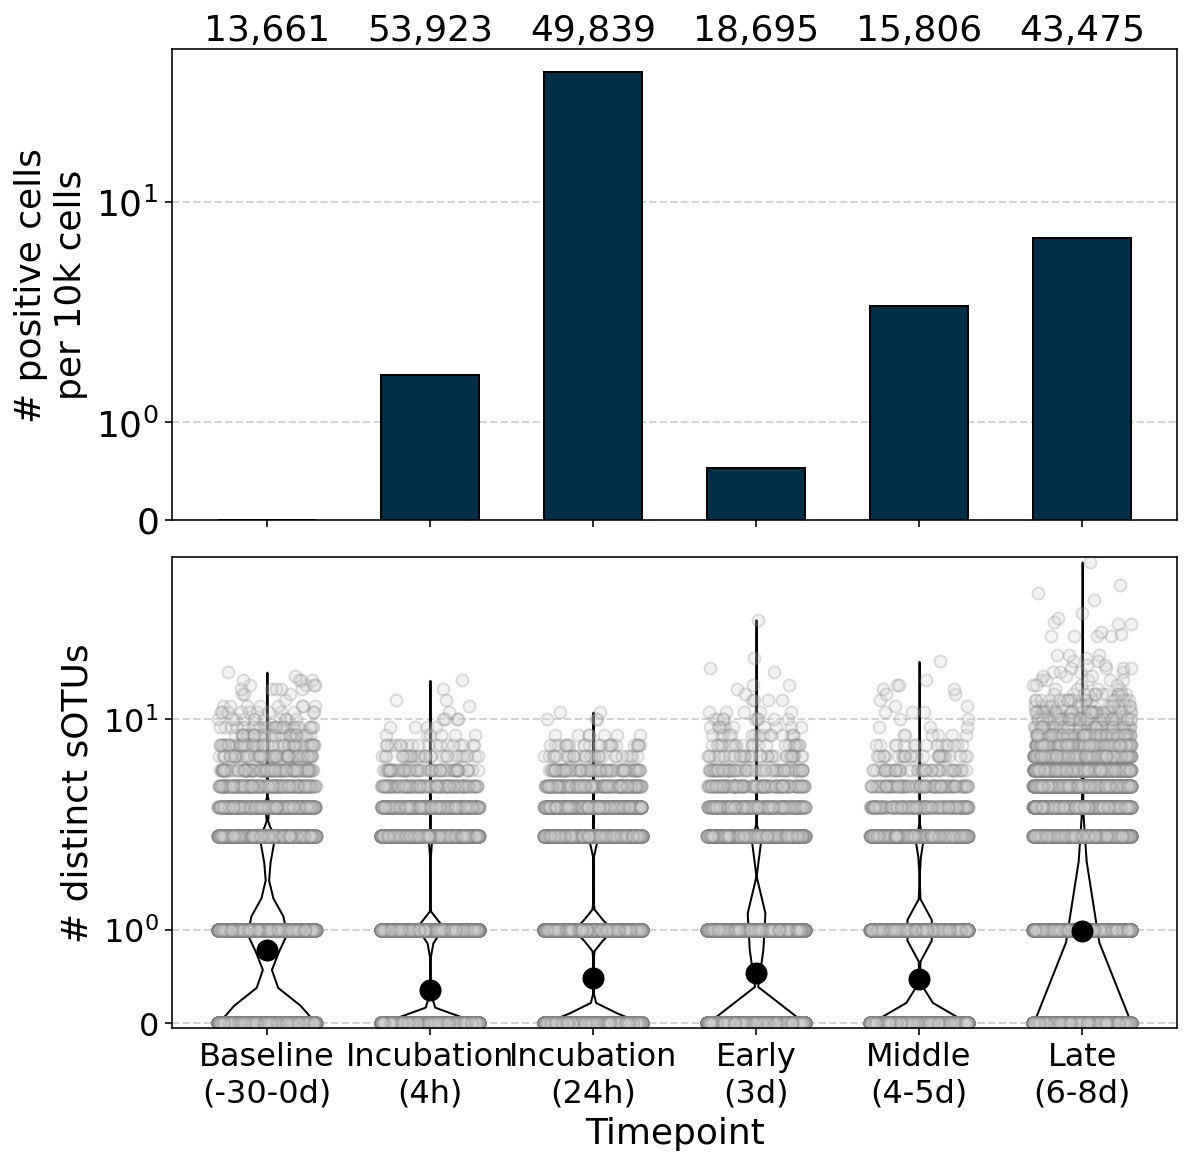

In [30]:
fig, axs = plt.subplots(figsize=(9, 9), nrows=2, sharex=True)
fontsize = 18
width = 0.6
color = "#003049" # Change to #b266b3 for black bkg
background = "white"
label_color = "black"
grid_color = "lightgrey"

samples = ["pre-infection", "4h", "24h", "early", "middle", "late"]
labels = ["Baseline\n(-30-0d)", "Incubation\n(4h)", "Incubation\n(24h)", "Early\n(3d)", "Middle\n(4-5d)", "Late\n(6-8d)"]
target_ids = id2tax[id2tax["species"].str.contains("Zaire ebolavirus")]["rep_ID"].unique()

# Plot number of ZEBOV counts per timepoint
ax = axs[0]

cellnum = []
total_num_cells = []
for sample in samples:
    total = len(palmdb_adata.obs[(palmdb_adata.obs["celltype"].notnull()) & (palmdb_adata.obs["dpi_grouped"] == sample)])
    total_num_cells.append(total)
    
    pos_cells = palmdb_adata[(palmdb_adata.obs["celltype"].notnull()) & (palmdb_adata.obs["dpi_grouped"] == sample), palmdb_adata.var.index.isin(target_ids)].X.sum()
    cellnum.append((pos_cells / total) * 10000)
    
    print(f"Total number of positive cells in sample '{sample}': {pos_cells}")

x = np.arange(len(labels))

ax.bar(
    x,
    cellnum,
    width=width,
    # label=f"EBOV+ cells",
    color=color,
    alpha=1,
    edgecolor=label_color,
)

# Add total number of cells per condition
for x_idx, nc in enumerate(total_num_cells):
    ax.text(x_idx, 75, "{:,}".format(nc), color=label_color, fontsize=fontsize, va="bottom", ha="center")

ax.set_yscale("symlog")
# ax.set_ylim(bottom=1)
ax.set_ylabel("# positive cells\nper 10k cells", fontsize=fontsize, color=label_color)
# ax.set_xlabel("Timepoint", fontsize=fontsize)
# ax.legend(loc="upper left", fontsize=fontsize)

# ax.set_xticks(x, samples, rotation=0, ha="center")

ax.tick_params(axis="both", labelsize=fontsize, colors=label_color)
# ax.set_title(
#     f"Number of Zaire ebolavirus (ZEBOV) positive cells over time",
#     fontsize=fontsize + 2,
# )

ax.grid(True, which="both", color=grid_color, ls="--", lw=1)
ax.set_axisbelow(True)
ax.xaxis.grid(False)

# Plot number of distinct sOTUS detected
ax = axs[1]

all_species_nums = [] # Collect all vector for significance testing
x = np.arange(len(samples))
for i, cluster in enumerate(samples):
    # Get number of virus species with non-zero counts per cell in cluster
    array = np.array(palmdb_adata[(palmdb_adata.obs["celltype"].notnull()) & (palmdb_adata.obs['dpi_grouped']==cluster), ].X.todense()) # palmdb_adata.var["v_type"] == "macaca_only" ADD AS SUPPLEMENT TO SHOW THAT # VIRUSES INCREASES?
    species_nums = (array > 0).sum(1)
    mean = np.mean(species_nums)
    
    v = ax.violinplot(species_nums, [x[i]], widths=width, vert=True, showmedians=False, showextrema=False)
    for pcidx, pc in enumerate(v["bodies"]):
        pc.set_facecolor(background)
        pc.set_edgecolor(label_color)
        pc.set_alpha(1)
    ax.scatter([x[i]]*len(species_nums) + rand_jitter([x[i]]*len(species_nums), 0.3), species_nums, alpha=0.25, color=grid_color, edgecolor="grey")
    ax.scatter(x[i], mean, s=100, color=label_color)
    
    all_species_nums.append(species_nums)

ax.set_yscale("symlog")
# ax.set_ylim(bottom=0)
ax.set_xticks(x, labels)
ax.tick_params(axis='both', labelsize=fontsize-2, colors=label_color)
ax.set_ylabel("# distinct sOTUs", fontsize=fontsize, color=label_color)
ax.set_xlabel("Timepoint", fontsize=fontsize, color=label_color)
ax.margins(y=0.01)

ax.grid(True, which="both", color=grid_color, ls="--", lw=1)
ax.set_axisbelow(True)
ax.xaxis.grid(False)

for ax in axs:
    ax.spines['bottom'].set_color(label_color)
    ax.spines['top'].set_color(label_color)
    ax.spines['right'].set_color(label_color)
    ax.spines['left'].set_color(label_color)

# plt.tight_layout()
plt.subplots_adjust(hspace=0.08)

plt.savefig("figures/4.3_ebola_counts_over_time_bus+d-list.png", dpi=300, bbox_inches="tight")

fig.show()

Perform Welch’s t-test between 7/8d sOTUs array and all others:

In [10]:
# from scipy.stats import ttest_ind

# for y in all_species_nums[:-1]:
#     x = all_species_nums[-1]
#     stat, p = ttest_ind(x, y, equal_var=False)
    
#     print(stat, p)

Timepoint 7/8d significanlty differs from all other arrays. However, the p values are very very low and many of the other timepoints also significanlty differ from some others.

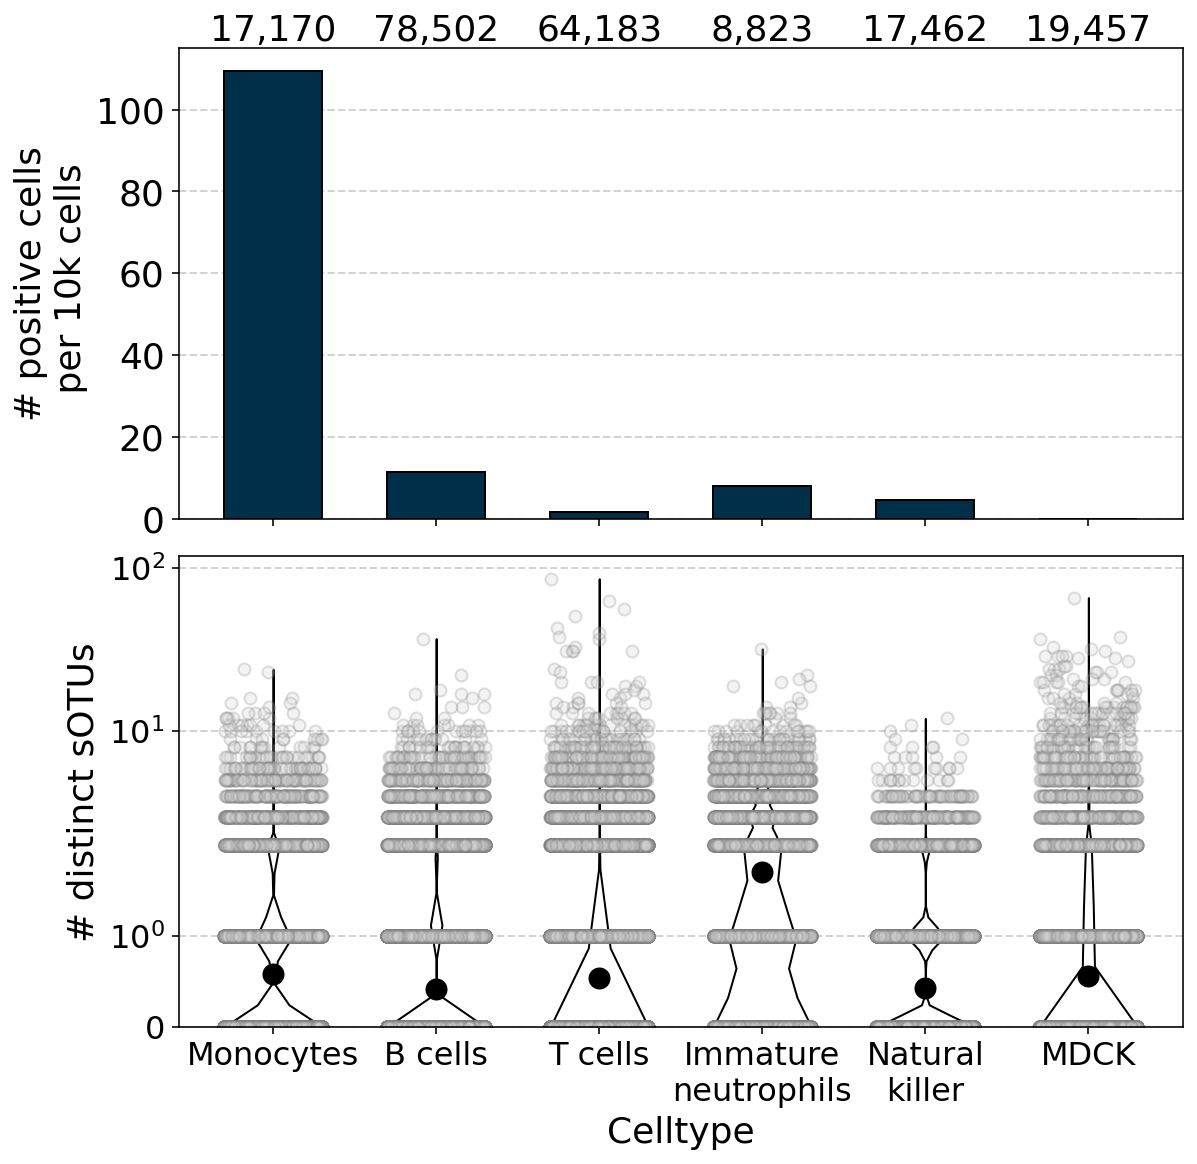

In [31]:
fig, axs = plt.subplots(figsize=(9, 9), nrows=2, sharex=True)
fontsize = 18
width = 0.6
color = "#003049" # Change to #b266b3 for black bkg
background = "white"
label_color = "black"
grid_color = "lightgrey"

celltypes = [
    "Monocytes",
    "B cells",
    "T cells",
    "Immature neutrophils",
    "Natural killer",
    # "Undefined",
    "MDCK"
]

labels= [
    "Monocytes",
    "B cells",
    "T cells",
    "Immature\nneutrophils",
    "Natural\nkiller",
    # "Undefined",
    "MDCK"
]

# Plot number of ZEBOV counts per celltype
ax=axs[0]

target_ids = id2tax[id2tax["species"].str.contains("Zaire ebolavirus")]["rep_ID"].unique()

cellnum = []
total_num_cells = []
for ct in celltypes:
    if ct == "MDCK":
        count = palmdb_adata[palmdb_adata.obs["species"] == "canis_lupus_familiaris", palmdb_adata.var.index.isin(target_ids)].X.sum()
        total = len(palmdb_adata.obs[palmdb_adata.obs["species"] == "canis_lupus_familiaris"])
        cellnum.append((count / total) * 10000)
        total_num_cells.append(total)
    else:
        count = palmdb_adata[palmdb_adata.obs["celltype"] == ct, palmdb_adata.var.index.isin(target_ids)].X.sum()
        total = len(palmdb_adata.obs[palmdb_adata.obs["celltype"] == ct])
        cellnum.append((count / total) * 10000)
        total_num_cells.append(total)

x = np.arange(len(celltypes))

ax.bar(
    x,
    cellnum,
    width=width,
    color=color,
    alpha=1,
    edgecolor=label_color,
)

# Add total number of cells per condition
for x_idx, nc in enumerate(total_num_cells):
    ax.text(x_idx, 115, "{:,}".format(nc), color=label_color, fontsize=fontsize, va="bottom", ha="center")

# ax.set_yscale("log")
ax.set_ylabel("# positive cells\n per 10k cells", fontsize=fontsize, color=label_color)
# ax.set_xlabel("Celltype", fontsize=fontsize)
# ax.legend(loc="upper left", fontsize=fontsize)

# ax.set_xticks(x, labels, rotation=0, ha="center")

ax.tick_params(axis="both", labelsize=fontsize, colors=label_color)
# ax.set_title(f"Number of Zaire ebolavirus (ZEBOV) positive cells per celltype", fontsize=fontsize)

ax.grid(True, which="both", color=grid_color, ls="--", lw=1)
ax.set_axisbelow(True)
ax.xaxis.grid(False)

# Plot number of distinct sOTUS detected
ax=axs[1]

x = np.arange(len(celltypes))
for i, cluster in enumerate(celltypes):
    # Get number of virus species with non-zero counts per cell in cluster
    if cluster == "MDCK":
        array = np.array(palmdb_adata[palmdb_adata.obs['species']=="canis_lupus_familiaris", :].X.todense()) # palmdb_adata.var["v_type"] == "canis_lupus_familiaris"
    else:
        array = np.array(palmdb_adata[palmdb_adata.obs['celltype']==cluster, :].X.todense())  # palmdb_adata.var["v_type"] == "macaca_only"
    species_nums = (array > 0).sum(1)
    mean = np.mean(species_nums)
    
    v = ax.violinplot(species_nums, [x[i]], widths=width, vert=True, showmedians=False, showextrema=False)
    for pcidx, pc in enumerate(v["bodies"]):
        pc.set_facecolor(background)
        pc.set_edgecolor(label_color)
        pc.set_alpha(1)
    ax.scatter([x[i]]*len(species_nums) + rand_jitter([x[i]]*len(species_nums), 0.3), species_nums, alpha=0.25, color=grid_color, edgecolor="grey")
    ax.scatter(x[i], mean, s=100, color=label_color)

ax.set_yscale("symlog")
ax.set_ylim(bottom=0)
ax.set_xticks(x, labels)
ax.tick_params(axis='both', labelsize=fontsize-2, colors=label_color)
ax.set_ylabel("# distinct sOTUs", fontsize=fontsize, color=label_color)
ax.set_xlabel("Celltype", fontsize=fontsize, color=label_color)
ax.margins(y=0.01)

# ax.set_title(f"Number of distinct sOTUs detected per celltype", fontsize=fontsize)

ax.grid(True, which="both", color=grid_color, ls="--", lw=1)
ax.set_axisbelow(True)
ax.xaxis.grid(False)

for ax in axs:
    ax.spines['bottom'].set_color(label_color)
    ax.spines['top'].set_color(label_color)
    ax.spines['right'].set_color(label_color)
    ax.spines['left'].set_color(label_color)

# plt.tight_layout()
plt.subplots_adjust(hspace=0.08)

plt.savefig("figures/4.3_ebola_counts_per_celltype_bus+d-list.png", dpi=300, bbox_inches="tight")

fig.show()

___
# Plot EBOV counts per celltype per timepoint 
-> Too few cells per group to do this.

In [12]:
# fig, ax = plt.subplots(figsize=(20, 10))
# fontsize = 14

# # colors = ["#b8dd5a", "#64aa37", "#3e8938", "#b3cde0", "#005c96", "gold", "orange", "#e06237", "#c73d32", "#b2172b", "#7d0d0f"]
# colors = ["#b3cde0", "#005c96", "gold", "orange", "#e06237", "#b2172b", "#7d0d0f"]

# width = 0.1
# target_ids = id2tax[id2tax["species"].str.contains("Zaire ebolavirus")][
#     "rep_ID"
# ].unique()

# celltypes = [
#     "Monocytes",
#     "B cells",
#     "Plasmablast",
#     "T cells",
#     "Immature neutrophils",
#     "Natural killer",
#     # "Undefined"
# ]

# for i, celltype in enumerate(celltypes):
#     c_idx = 0
#     for jitter, tp in zip(
#         # [-width*5, -width*4, -width*3, -width*2, -width, 0, width, width*2, width*3, width*4, width*5],
#         [-width*3, -width*2, -width, 0, width, width*2, width*3],
#         # ["-30d", "-4d", "0d", "4h", "24h", "3d", "4d", "5d", "6d", "7d", "8d"]
#         ["4h", "24h", "3d", "4d", "5d", "6d", "7d/8d"],
#     ):
#         count = palmdb_adata[
#             (palmdb_adata.obs["dpi_clean_merged"] == tp)
#             & (palmdb_adata.obs["celltype"] == celltype),
#             palmdb_adata.var.index.isin(target_ids),
#         ].X.sum()

#         num_cells = len(
#             palmdb_adata[
#                 (palmdb_adata.obs["dpi_clean_merged"] == tp)
#                 & (palmdb_adata.obs["celltype"] == celltype),
#                 palmdb_adata.var.index.isin(target_ids),
#             ]
#         )
        
#         # Count per 1000 cells
#         norm_count = (count / num_cells) * 10000
        
#         if num_cells < 100:
#             print(f"{celltype} {tp}: ", num_cells)
        
#         if i == 0:
#             ax.bar(
#                 i + jitter,
#                 norm_count,
#                 width=width,
#                 color=colors[c_idx],
#                 edgecolor="black", 
#                 label=tp,
#             )
#         else:
#             ax.bar(i + jitter, norm_count, width=width, color=colors[c_idx], edgecolor="black")
            
#         # Add total number of cells above bar
#         ax.text(i + jitter, norm_count+10, f"{'{:,}'.format(num_cells)}", color="black", fontsize=fontsize-2, rotation=90, va="bottom", ha="center")

#         c_idx += 1

# # ax.set_yscale("symlog")
# ylim = 950
# ax.set_yticks(np.arange(0, ylim, 20))
# ax.set_ylim(top=ylim)
# ax.legend(title="Timepoint", title_fontsize=fontsize, fontsize=fontsize)
# ax.set_ylabel("Zaire ebolavirus counts per 10k cells", fontsize=fontsize)
# ax.set_xticks(range(len(celltypes)))
# ax.set_xticklabels(celltypes)

# ax.tick_params(axis="both", labelsize=fontsize)
# ax.grid(True, which="both", color="lightgray", ls="--", lw=1)
# ax.set_axisbelow(True)

# # plt.savefig("figures/4.3_ebov_tropism.png", dpi=300, bbox_inches="tight", transparent=True)

# fig.show()

In [13]:
# fig, ax = plt.subplots(figsize=(17, 15))
# fontsize = 14

# # colors = ["#b8dd5a", "#64aa37", "#3e8938", "#b3cde0", "#005c96", "gold", "orange", "#e06237", "#c73d32", "#b2172b", "#7d0d0f"]
# colors = ["#b3cde0", "#005c96", "gold", "orange", "#e06237", "#b2172b", "#7d0d0f"]

# width = 0.1
# target_ids = id2tax[id2tax["species"].str.contains("Zaire ebolavirus")][
#     "rep_ID"
# ].unique()

# celltypes = [
#     "Monocytes",
#     "B cells",
#     # "Plasmablast",
#     "T cells",
#     "Immature neutrophils",
#     "Natural killer",
#     # "Undefined"
# ]

# for i, celltype in enumerate(celltypes):
#     c_idx = 0
#     for jitter, tp in zip(
#         # [-width*5, -width*4, -width*3, -width*2, -width, 0, width, width*2, width*3, width*4, width*5],
#         [-width*3, -width*2, -width, 0, width, width*2, width*3],
#         # ["-30d", "-4d", "0d", "4h", "24h", "3d", "4d", "5d", "6d", "7d", "8d"]
#         ["4h", "24h", "3d", "4d", "5d", "6d", "7d/8d"],
#     ):

#         num_cells = len(
#             palmdb_adata[
#                 (palmdb_adata.obs["dpi_clean_merged"] == tp)
#                 & (palmdb_adata.obs["celltype"] == celltype),
#                 palmdb_adata.var.index.isin(target_ids),
#             ]
#         )

#         # Number of EBOV+ cells
#         num_cells_ebov = count_true(
#             nd(
#                 palmdb_adata[
#                     (palmdb_adata.obs["dpi_clean_merged"] == tp)
#                     & (palmdb_adata.obs["celltype"] == celltype),
#                     palmdb_adata.var.index.isin(target_ids),
#                 ].X.todense()
#                 > 0
#             )
#         )
        
#         print(f"{celltype} {tp}: ",num_cells_ebov)
        
#         # Count per 10k cells
#         norm_count = (num_cells_ebov / num_cells) * 10000

#         if num_cells < 100:
#             print(f"{celltype} {tp}: ", num_cells)

#         if i == 0:
#             ax.bar(
#                 i + jitter,
#                 norm_count,
#                 width=width,
#                 color=colors[c_idx],
#                 edgecolor="black",
#                 label=tp,
#             )
#         else:
#             ax.bar(
#                 i + jitter,
#                 norm_count,
#                 width=width,
#                 color=colors[c_idx],
#                 edgecolor="black",
#             )

#         # Add total number of cells above bar
#         ax.text(i + jitter, norm_count+1, f"{'{:,}'.format(num_cells)}", color="black", fontsize=fontsize-3, rotation=90, va="bottom", ha="center")
        
#         c_idx += 1

# # ax.set_yscale("symlog")
# ylim = 400
# ax.set_yticks(np.arange(0, ylim, 20))
# ax.set_ylim(top=ylim)
# ax.legend(title="Timepoint", title_fontsize=fontsize, fontsize=fontsize)
# ax.set_ylabel("Number of Zaire Ebolavirus+ cells per 10k cells", fontsize=fontsize)
# ax.set_xticks(range(len(celltypes)))
# ax.set_xticklabels(celltypes)

# ax.tick_params(axis="both", labelsize=fontsize)
# ax.grid(True, which="both", color="lightgray", ls="--", lw=1)
# ax.set_axisbelow(True)

# plt.savefig("figures/4.3_ebov_tropism.png", dpi=300, bbox_inches="tight", transparent=True)

# fig.show()

___

# Plot number of virus species per celltype per timepoint

Get normalized fractions of timepoint per celltype cluster:

In [14]:
# # Merge timpeoints 7d and 8d due to few counts
# new_tps = []
# for tp in host_adata.obs["dpi_clean"].values:
#     if tp == "7d" or tp == "8d":
#         new_tps.append("7d/8d")
#     else:
#         new_tps.append(tp)

# host_adata.obs["dpi_clean_merged"] = new_tps

In [15]:
# Compute fraction of cells occupied per time point for each celltype cluster
df_normalized = pd.DataFrame()

adata = host_adata.copy()
groups = "celltype_clusters"
fractions = "dpi_clean_merged"
group_order = [
    "B cells 1",
    "B cells 2",
    "B cells 3",
    "B cells 4",
    "B cells 5",
    "B cells 6",
    "B cells 7",
    "T cells 1",
    "T cells 2",
    "T cells 3",
    "T cells 4",
    "T cells 5",
    "Natural killer 1",
    "Monocytes 1",
    "Monocytes 2",
    "Immature neutrophils 1",
    # "Undefined 1", # Only has 12 cells
    "Undefined 2",
    "Undefined 3"
]
group_order.reverse()

# Normalize each celltype count to total number of cells in that fraction by dividing by total
df_normalized = (
    (
        adata.obs.groupby(groups)[fractions].value_counts()
        / adata.obs.groupby(fractions)["species"].count()
    )
    .unstack()
    .fillna(0)
)

# Convert columns to string
df_normalized.columns = df_normalized.columns.astype(str)
# Get total normalized count
df_normalized["total_normalized_count"] = df_normalized.sum(axis=1).values

# Compute fraction of normalized total count for each sample
for sample in adata.obs[fractions].unique():
    df_normalized[f"{sample}_fraction"] = (
        df_normalized[sample] / df_normalized["total_normalized_count"]
    ).values

# Get total cellcount
df_normalized["total_cellcount"] = adata.obs.groupby(groups).size().values.astype(int)

# Sort data
if group_order:
    df_normalized = df_normalized.reindex(group_order)
else:
    df_normalized = df_normalized.sort_values(
        list(df_normalized.filter(like="_fraction").columns.values)
    )

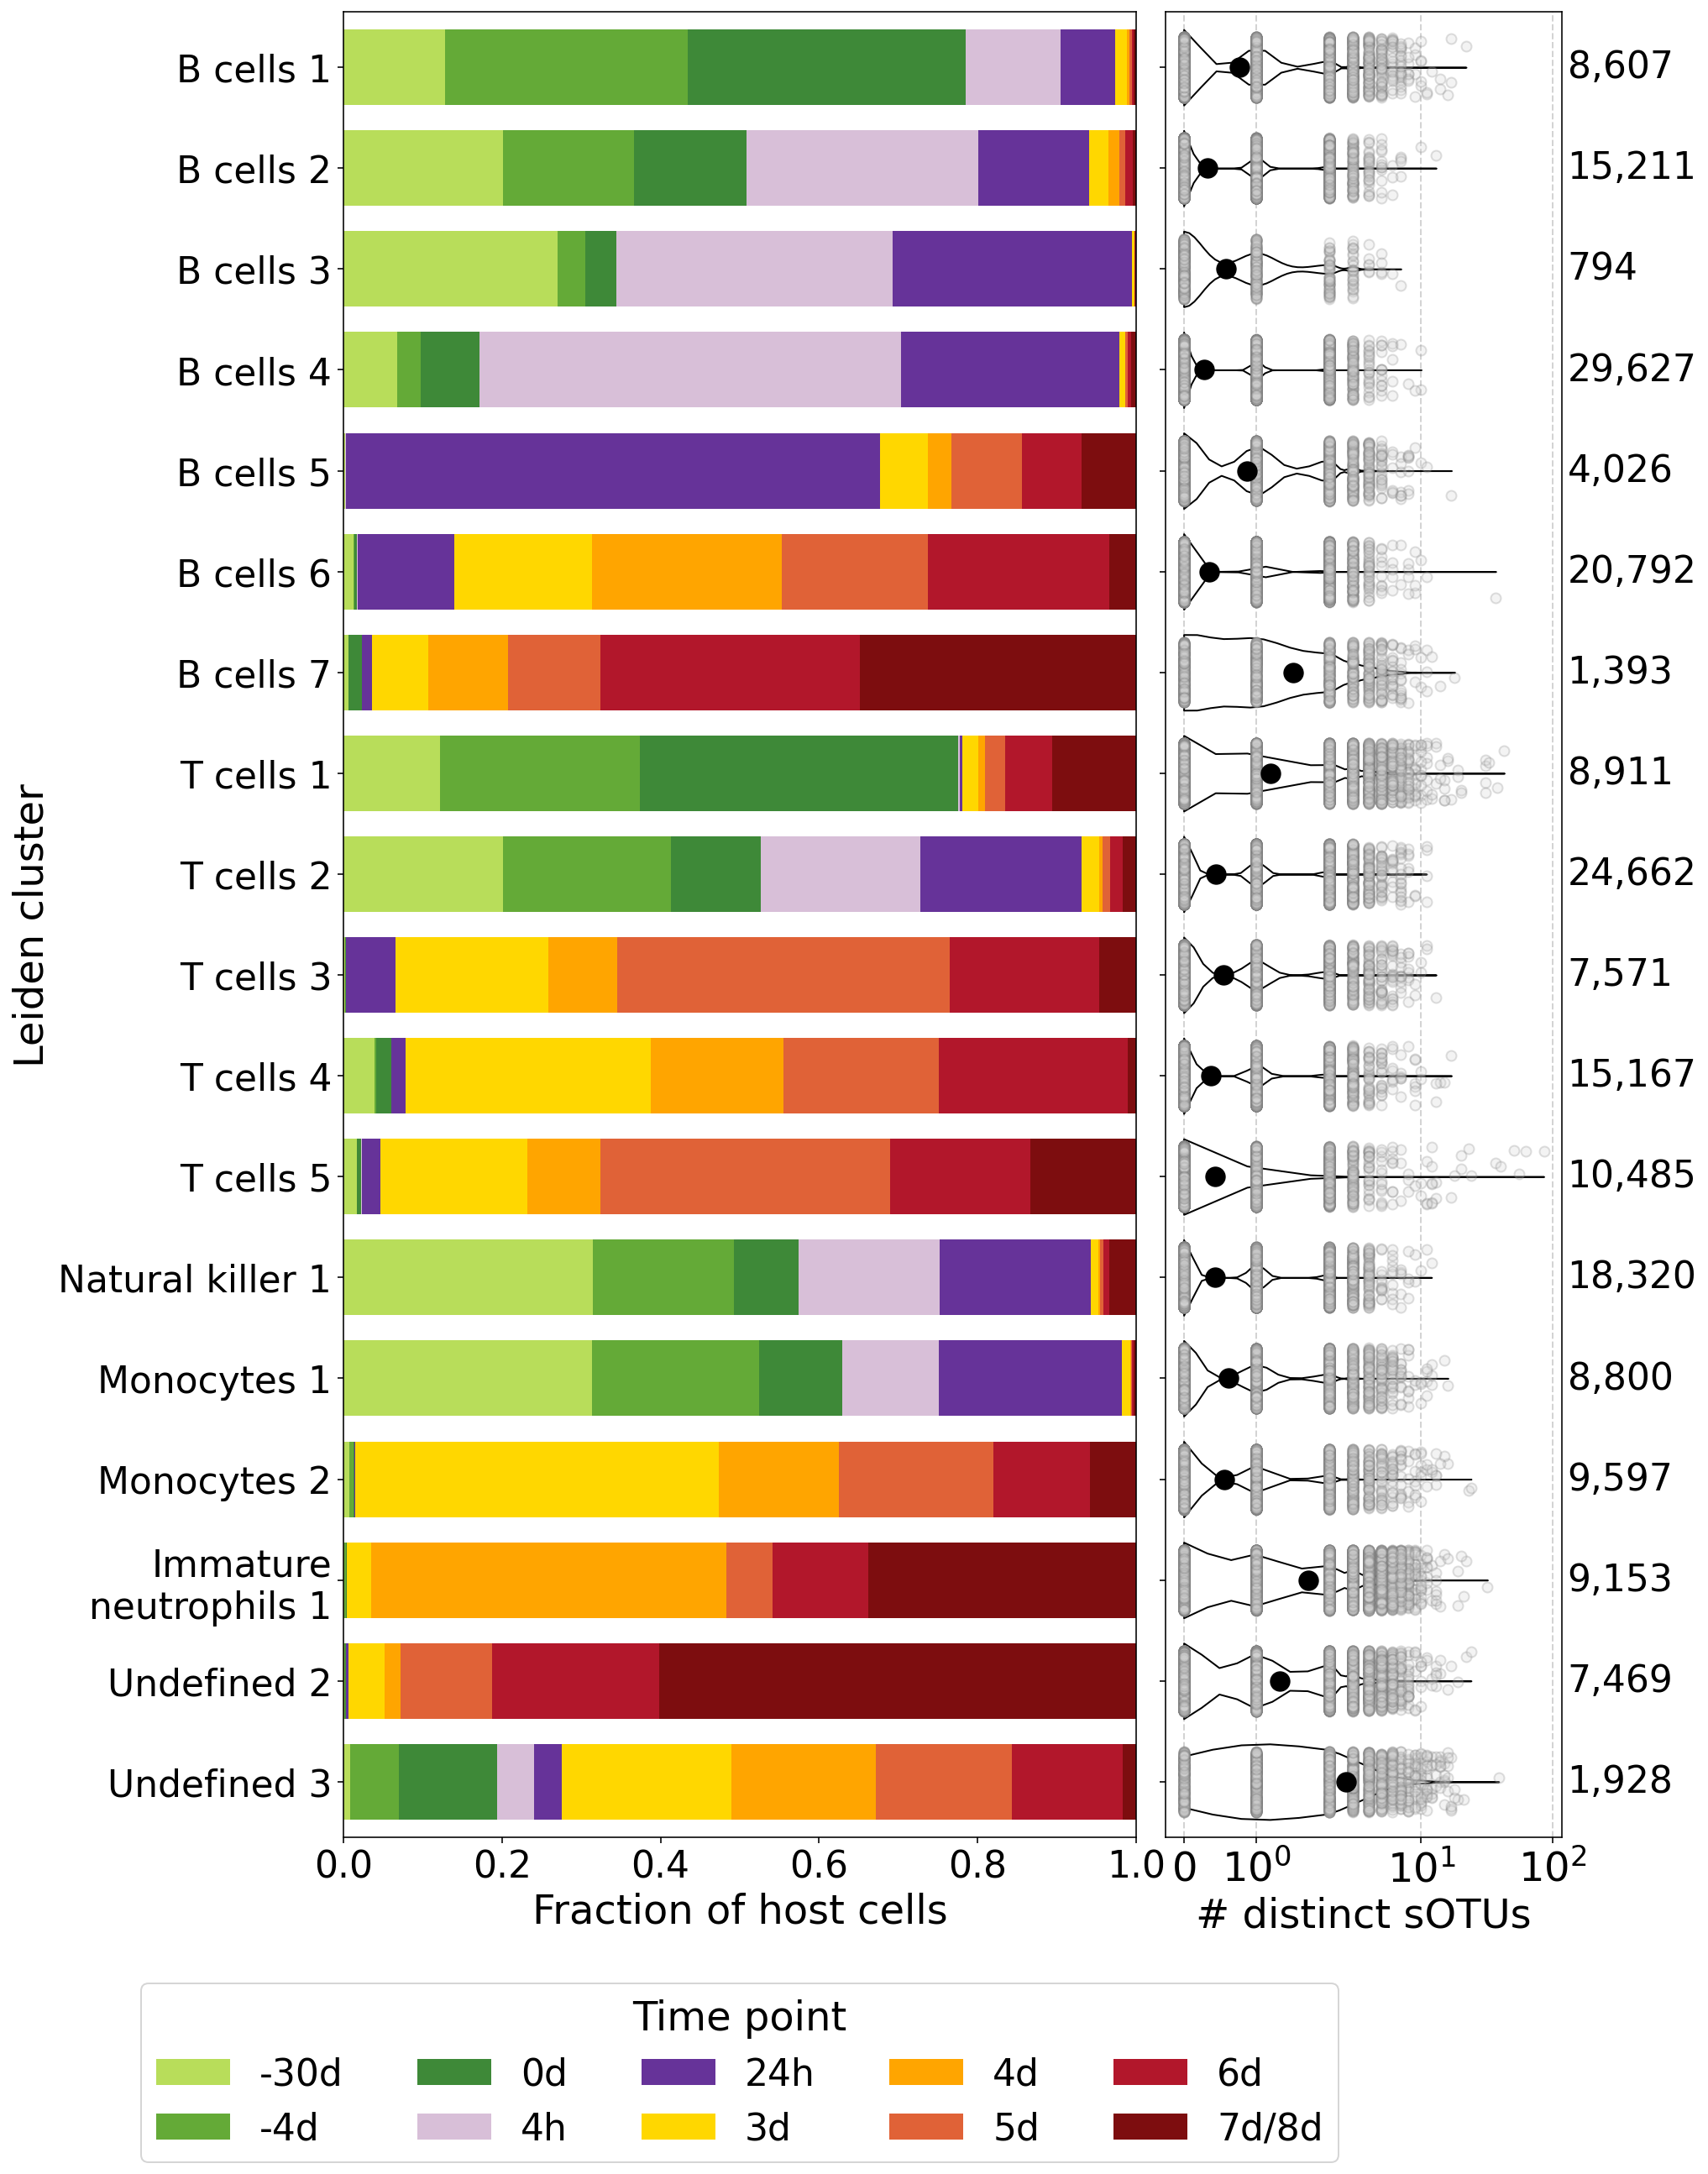

In [33]:
fig, axs = plt.subplots(figsize=(13, 20), ncols=2, sharey=True, gridspec_kw={'width_ratios': [2, 1]})
# fig, axs = plt.subplots(figsize=(15, 20), ncols=2, sharey=True)

# Plot host celltype fractions
ax = axs[0]
width = 0.75
alpha = 1
fontsize = 22

colors=["#b8dd5a", "#64aa37", "#3e8938", "thistle", "rebeccapurple", "gold", "orange", "#e06237", "#b2172b", "#7d0d0f"]
frac_order=['-30d', '-4d', '0d', '4h', '24h', '3d', '4d', '5d', '6d', '7d/8d']
    
clusters = df_normalized.index.values
cellcounts = df_normalized["total_cellcount"].values

previous_samples = 0
for c_idx, sample in enumerate(frac_order):
    ax.barh(
        clusters,
        df_normalized[f"{sample}_fraction"].values,
        width,
        left=previous_samples,
        color=colors[c_idx],
        label=sample,
        alpha=alpha,
    )
    previous_samples = previous_samples + df_normalized[f"{sample}_fraction"].values

# Get y tick labels and split long label
labels = []
for label in clusters:
    if label == 'Immature neutrophils 1':
        labels.append('Immature\nneutrophils 1')
    else:
        labels.append(label)
ax.set_yticklabels(labels, fontsize=fontsize)

# ax.legend(bbox_to_anchor=(-0.25, 1.007), fontsize=fontsize)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07), ncol=5, fontsize=fontsize, title="Time point", title_fontsize=fontsize+2)

# ax.set_title(title, y=1.0, pad=20, fontsize=fontsize + 2)
ax.set_xlabel("Fraction of host cells", fontsize=fontsize+2)
ax.set_ylabel("Leiden cluster", fontsize=fontsize+2)
ax.tick_params(axis="both", labelsize=fontsize)

ax.margins(x=0.3, y=0.01)
ax.grid(False)


# Plot total number of virus species per celltype cluster
ax = axs[1]

x = np.arange(len(group_order))
for i, cluster in enumerate(group_order):
    # Get number of virus species per cell in cluster
    array = np.array(palmdb_adata[palmdb_adata.obs['celltype_clusters']==cluster, :].X.todense())
    species_nums = (array.astype(int) != 0).sum(1)
    mean = np.mean(species_nums)
    
    v = ax.violinplot(species_nums, [x[i]], widths=width, vert=False, showmedians=False, showextrema=False)
    for pcidx, pc in enumerate(v["bodies"]):
        pc.set_facecolor("white")
        pc.set_edgecolor("black")
        pc.set_alpha(1)
    ax.scatter(species_nums, [x[i]]*len(species_nums) + rand_jitter([x[i]]*len(species_nums), 0.3), alpha=0.25, edgecolor="grey", color="lightgrey")
    ax.scatter(mean, x[i], s=125, color="black")
    
# Add total cell count next to each bar
for index, value in enumerate(cellcounts):
    ax.text(x=130, y=index, s="{:,}".format(value), size=fontsize, ha="left", va="center")

ax.set_xscale("symlog")

# ax.set_xlim(left=0, right=100)
# ax.set_yticks(x, clusters)
ax.tick_params(axis='both', labelsize=fontsize+2)
ax.set_xlabel("# distinct sOTUs", fontsize=fontsize+2)
ax.margins(y=0.01)

ax.grid(True, which="both", color="lightgray", ls="--", lw=1)
ax.set_axisbelow(True)
ax.yaxis.grid(False)

plt.subplots_adjust(wspace=0.05)

plt.savefig(
    f"figures/4.3_host_celltype_fractions_virus_species_counts_bus+d-list.png",
    dpi=300,
    bbox_inches="tight",
)

fig.show()

Color viruses by shared/macaque/MDCK/undefined -> Cannot do this because individual cells might have a combination of these

In [22]:
import matplotlib
matplotlib.colors.to_hex("rebeccapurple", keep_alpha=False)

'#663399'